<h1 style="color:black;font-size:40px"><center>ACTIVIDAD 1</center></h1>

***Modele una solución MapReduce, sugiriendo la utilización de funciones combiners en los casos que considere necesario, que permita obtener lo que se pide en cada inciso.***

A continuación se detalla la solución implementada en cada inciso, explicando en cada caso la tarea de cada job, seguido del código. Obsérvese que en varios jobs, con el objetivo de utilizar combiners...
- El formato de la salida de las funciones `map` fue adecuado para que admita los campos necesarios en una función `combiner` (cuyo output debe ser necesariamente igual a el de la función `map`).
- El formato de la salida de las funciones `reduce` fue adecuado a ese mismo formato, para que se pueda usar la misma función `reduce` como función `combiner`.

In [ ]:
# SOLO SI CORRIENDO EN COLAB
import sys, os
!git clone https://github.com/tvillani22/BD_UNLP.git 
sys.path.append('/content/BD_UNLP/') # si se corre en Colab
os.chdir('BD_UNLP/')

In [1]:
# Luego de cargar archivo MRE.py en carpeta ppal del repo
import sys
sys.path.append('../')
from MRE import Job

# Parámetros generales
data_path = '../Data/website/'
inputDir = data_path + 'input/'
tempDir1 = data_path + "temp/temp1"
tempDir2 = data_path + "temp/temp2"

***
## Inciso 1
>**Obtener el usuario que más páginas distintas visitó.**

***En la solución implementada, el primer job consolida las visitas de cada usuario a cada página usando esa tupla como `k2`, y calcula el número de visitas y el tiempo total, para ese par. Esto último no es necesario y solo se hace aquí para generalizar este primer job y poder usarlo como primer job en los otros incisos.***

In [2]:
outputDir = data_path + 'output/output1/'

def fmap(key, value, context):
    id_user = key
    id_page = value.split()[0]
    time = value.split()[1]
    context.write((id_user, id_page), (1, time)) 

def fred(key, values, context):
    id_user = key[0]
    id_page = key[1]
    t_total = 0
    n_total = 0
    for v in values:
        n_acum_loc = v[0]
        t_acum_loc = v[1]
        n_total += int(n_acum_loc)
        t_total += int(t_acum_loc)
    context.write((id_user, id_page), (n_total, t_total))

job = Job(inputDir, tempDir1, fmap, fred)
job.setCombiner(fred)

***El segundo job acumula, para cada usuario, el número de páginas que visitó (sin importar cuántas veces cada una).***

In [3]:
def fmap2(key, value, context):
    id_user = key
    context.write(id_user, 1)

def fred2(key, values, context):
    id_user = key
    num_sitios = 0
    for v in values:
        num_sitios += v
    context.write(id_user, num_sitios)

job2 = Job(tempDir1, tempDir2, fmap2, fred2)
job2.setCombiner(fred2)

***El tercer job busca el usuario que más páginas distintas visitó.***

In [4]:
def fmap3(key, value, context):
    id_user = key
    num_sitios = value
    context.write(99, (id_user, num_sitios))

def fred3(key, values, context):
    num_sitios_max = 0
    id_user_nmax = None
    for v in values:
        id_user = v[0]
        num_sitios = int(v[1])
        if num_sitios >  num_sitios_max:
            num_sitios_max = num_sitios
            id_user_nmax = id_user
    context.write(99, (id_user_nmax, num_sitios_max))
    
job3 = Job(tempDir2, outputDir, fmap3, fred3)
job3.setCombiner(fred3)                        

***Ejecutando...***

In [5]:
success = job.waitForCompletion()

if success:
    print('Job 1 completado con éxito.')
    success = job2.waitForCompletion()

if success:
    print('Job 2 completado con éxito.')
    success = job3.waitForCompletion()

if success:
    print('Job 3 completado con éxito.')
    with open(outputDir + 'output.txt', 'rt') as fh:    
        linea = next(fh)
        id_user_nmax = linea.rstrip().split()[1]
        num_sitios_max = linea.rstrip().split()[2]
    print(f'\nRESULTADO \nEl usuario que más páginas distintas visitó '
          f'fue el usuario número {id_user_nmax}, con {num_sitios_max}.')   

Job 1 completado con éxito.
Job 2 completado con éxito.
Job 3 completado con éxito.

RESULTADO 
El usuario que más páginas distintas visitó fue el usuario número 9458, con 6.


***Y el DAG para este proceso es...***
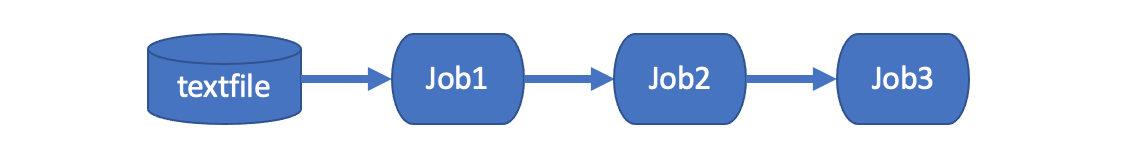

***
## Inciso 2
>**Obtener la página más visitada (en cuanto a tiempo de visita) por cada usuario siempre que la página haya sido visitada más de V veces por ese usuario (V es parámetro de la consulta).**

***En la solución implementada el primer Job, igual al del inciso anterior, consolida las visitas de cada usuario a cada página usando esa tupla como `k2`, y calcula el número de visitas y el tiempo total, para ese par.*** 

In [6]:
outputDir = data_path + "output/output2/"
V = 1  # parámetro de visitas minimas
parametros = {'visitas_minimas': V}

job = Job(inputDir, tempDir1, fmap, fred)
job.setCombiner(fred)

***El segundo Job busca, para cada usuario, la página que tiene el tiempo máximo de visita por ese usuario, guardando también el número de visitas que se hicieron. Finalmente, solo incluye el par usuario-página en el output si ese número de visitas es superior al parámetro V. En este caso, las funciones `combiner` y `reduce` pueden hacerse muy similares, pero no iguales. Por ello, para ahorrar código, se las implementa a través de una tercera función llamada `buscar_tmax()`.***

In [7]:
def fmap2(key, value, context):
    id_user = key
    id_page = value.split()[0]
    n_total = value.split()[1]
    t_total = value.split()[2]            
    context.write(id_user, (id_page, n_total, t_total))

def buscar_maxt(key, values, context):
    id_user = key
    t_max = 0
    n_tmax = None
    id_page_tmax = None
    for v in values:
        id_page = int(v[0])
        n_total = int(v[1])          
        t_total = int(v[2])
        if t_total > t_max:
            t_max = t_total
            id_page_tmax = id_page
            n_tmax = n_total
    return id_user, (id_page_tmax, n_tmax, t_max)

def fcomb(key, values, context):
    context.write(buscar_maxt(key, values, context))   
    
def fred2(key, values, context):
    id_user, tup = buscar_maxt(key, values, context)
    id_page_tmax, n_tmax, t_max = tup
    if int(n_tmax) > context['visitas_minimas']:
        context.write(id_user, (id_page_tmax, n_tmax, t_max)) 

job2 = Job(tempDir1, outputDir, fmap2, fred2)
job2.setParams(parametros)
job2.setCombiner(fcomb)

***Ejecutando...***

In [8]:
success = job.waitForCompletion()
if success:
    print('Job 1 completado con éxito.')
    success = job2.waitForCompletion()
if success:
    print('Job 2 completado con éxito.')
    n_lineas = sum(1 for line in open(outputDir + 'output.txt', 'rt'))
    if n_lineas == 0:
        print(f'No hay página que haya sido visitada más de {V} veces '
                'por un mismo usuario.')
    elif n_lineas < 10:
        with open(outputDir + 'output.txt', 'rt') as fh:    
            for linea in fh:
                id_user, id_page, n_visitas, time = linea.split()
                print(f'\nRESULTADO \nUsuario: {id_user}; Página: {id_page}; '
                      f'Número de visitas: {n_visitas}; Tiempo total: {time}')
    else:
        print('Resultado extenso, acceder en el output file.')

Job 1 completado con éxito.
Job 2 completado con éxito.

RESULTADO 
Usuario: 14448; Página: 1026; Número de visitas: 2; Tiempo total: 114


***Y el DAG para este proceso es...***
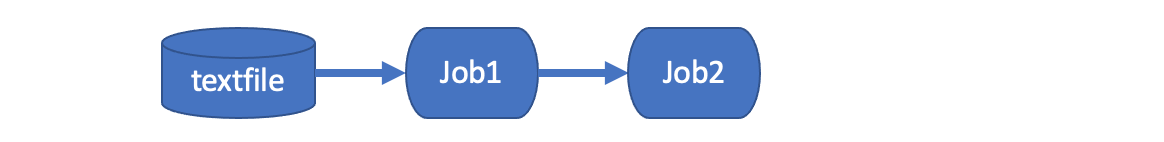

***
## Inciso 3
>**Obtener la página más visitada (en cuanto a cantidad de visitas, sin importar el tiempo de permanencia) por al menos U usuarios distintos (U es parámetro de la consulta).**

***En la solución implementada el primer job, igual al de los dos incisos previos, consolida las visitas de cada usuario a cada página usando esa tupla como `k2`, y calcula el número de visitas y el tiempo total para ese par.***

In [9]:
outputDir = data_path + "output/output3/"
U = 3  # parámetro de usuarios minimos
parametros = {'usuarios_minimos': U}

job = Job(inputDir, tempDir1, fmap, fred)
job.setCombiner(fred) 

***El segundo job cuenta, para cada página, el número total de usuarios y de visitas (contando todas las visitas de cada usuario) que recibió.***

In [10]:
def fmap2(key, value, context):
    id_user = key
    id_page = value.split()[0]
    n_visitas = int(value.split()[1])
    n_usuarios = 1 
    context.write(id_page, (n_visitas, n_usuarios))
    
def fred2(key, values, context):
    id_page = key
    n_visitas_tot = 0
    n_usuarios_tot = 0
    for v in values:
        n_visitas = v[0] 
        n_usuarios = v[1]
        n_visitas_tot += n_visitas
        n_usuarios_tot += n_usuarios
    context.write(id_page, (n_visitas_tot, n_usuarios_tot))

job2 = Job(tempDir1, tempDir2, fmap2, fred2)
job2.setCombiner(fred2) 

***El tercer job se queda con la página más visitada, entre aquellas que fueron visitadas por al menos U usuarios.***

In [11]:
def fmap3(key, value, context):
    id_page = key
    n_visitas_tot = int(value.split()[0])
    n_usuarios_tot = int(value.split()[1])
    context.write(99, (id_page, n_visitas_tot, n_usuarios_tot))

def fred3(key, values, context):
    n_visitas_max = 0
    id_page_vmax = None
    n_usuarios_vmax = 0
    # output nulo si en combiner ningun input cumple condicion
    for v in values:
        id_page = v[0]
        n_visitas = v[1]
        n_usuarios = v[2]
        if n_usuarios >= context['usuarios_minimos'] and n_visitas > n_visitas_max:
            n_visitas_max = n_visitas
            id_page_vmax = id_page
            n_usuarios_vmax = n_usuarios
    context.write(99, (id_page_vmax, n_visitas_max, n_usuarios_vmax))

job3 = Job(tempDir2, outputDir, fmap3, fred3)
job3.setCombiner(fred3)
job3.setParams(parametros)

***Ejecutando...***

In [12]:
success = job.waitForCompletion()

if success:
    print('Job 1 completado con éxito.')
    success = job2.waitForCompletion()

if success:
    print('Job 2 completado con éxito.')
    success = job3.waitForCompletion()

if success:
    print('Job 3 completado con éxito.')
    with open(outputDir + 'output.txt', 'rt') as fh:    
        linea = next(fh)
        id_page, n_visitas, n_usuarios = linea.rstrip().split()[1:]
    if id_page != 'None':
        print(f'\nRESULTADO \nLa página más visitada, entre aquellas que fueron '
              f'visitadas por al menos {U} usuarios, fue la {id_page}, que fue '
              f'visitada un total de {n_visitas} veces, por {n_usuarios} distintos.') 
    else:
        print(f'No hay página que haya sido visitada por al menos {U} usuarios.')

Job 1 completado con éxito.
Job 2 completado con éxito.
Job 3 completado con éxito.

RESULTADO 
La página más visitada, entre aquellas que fueron visitadas por al menos 3 usuarios, fue la 1694, que fue visitada un total de 8 veces, por 8 distintos.


***Y el DAG para este proceso es...***
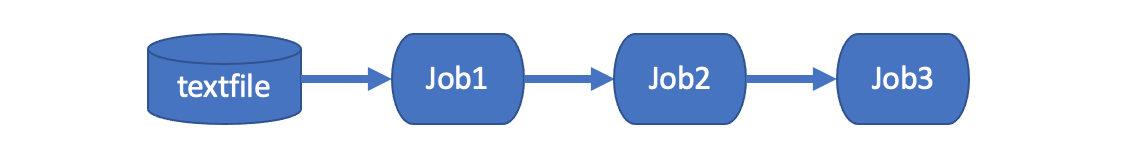

***
***